# Partie Machine learning : Modélisation paramétrique et Non-paramétrique

## CNT_SIN

### Modélisation paramétrique

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from scipy.stats.contingency import association
from scipy.stats import kendalltau, spearmanr, chi2_contingency, ttest_ind, bartlett, kruskal, mannwhitneyu,f_oneway
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os 

**Gestion du repertoire du courant**

In [9]:
os.getcwd()

'C:\\Users\\moham\\Downloads\\Partie Machine Learning'

In [10]:
os.chdir(r"C:\Users\moham\Downloads\Partie Machine Learning")

**Importation des Bases de Donnes**

*DB_CNT2, DB_TELEMATICS2 et DB_SIN2 sont respectivement DB_CNT, DB_TELEMATICS et DB_SIN apres nettoyage et traitement*

- DB_CNT2 + DB_SIN2 = CNT_SIN
- DB_TELEMATICS2 + DB_SIN2 = TEL_SIN

- CNT_SIN est le résultat de la jointure entre DB_CNT2 et DB_SIN2, avec remplacement des valeurs manquantes par 0. Cette décision découle de l'analyse du document accompagnant, qui indique que 95% des valeurs manquantes devraient être équivalentes à 0. Ces choix seront examinés plus en détail dans l'analyse à venir.

In [11]:
DB_CNT2=pd.read_csv('DB_CNT2.csv')
DB_SIN2=pd.read_csv('DB_SIN2.csv')
DB_TELEMATICS2=pd.read_csv('DB_TELEMATICS2.csv')
CNT_SIN = pd.merge(DB_CNT2, DB_SIN2, on='Id_pol', how='left') # 
CNT_SIN.fillna(0, inplace=True)

In [12]:
CNT_SIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100092 entries, 0 to 100091
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id_pol              100092 non-null  int64  
 1   Duration            100092 non-null  int64  
 2   Insured.age         100092 non-null  int64  
 3   Insured.sex         100092 non-null  object 
 4   Car.age             100092 non-null  int64  
 5   Marital             100092 non-null  object 
 6   Car.use             100092 non-null  object 
 7   Credit.score        100092 non-null  float64
 8   Region              100092 non-null  object 
 9   Annual.miles.drive  100092 non-null  float64
 10  Years.noclaims      100092 non-null  float64
 11  Territory           100092 non-null  int64  
 12  NB_Claim            100092 non-null  float64
 13  AMT_Claim           100092 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 10.7+ MB


**Changement de type**

In [13]:
CNT_SIN['Territory'] = CNT_SIN['Territory'].astype('object')

In [14]:
CNT_SIN['NB_Claim'] = CNT_SIN['NB_Claim'].astype('object') #category

In [15]:
CNT_SIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100092 entries, 0 to 100091
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id_pol              100092 non-null  int64  
 1   Duration            100092 non-null  int64  
 2   Insured.age         100092 non-null  int64  
 3   Insured.sex         100092 non-null  object 
 4   Car.age             100092 non-null  int64  
 5   Marital             100092 non-null  object 
 6   Car.use             100092 non-null  object 
 7   Credit.score        100092 non-null  float64
 8   Region              100092 non-null  object 
 9   Annual.miles.drive  100092 non-null  float64
 10  Years.noclaims      100092 non-null  float64
 11  Territory           100092 non-null  object 
 12  NB_Claim            100092 non-null  object 
 13  AMT_Claim           100092 non-null  float64
dtypes: float64(4), int64(4), object(6)
memory usage: 10.7+ MB


In [16]:
unique_values = {}
for column in CNT_SIN.select_dtypes(include=['object']):
    unique_values[column] = CNT_SIN[column].value_counts()
print(unique_values)

{'Insured.sex': Insured.sex
Male      53979
Female    46113
Name: count, dtype: int64, 'Marital': Marital
Married    69990
Single     30102
Name: count, dtype: int64, 'Car.use': Car.use
Commute       49647
Private       46406
Commercial     2610
Farmer         1429
Name: count, dtype: int64, 'Region': Region
Urban    78167
Rural    21925
Name: count, dtype: int64, 'Territory': Territory
43    3851
39    3685
85    3294
35    3283
38    2842
30    2714
18    2707
31    2617
84    2557
88    2514
89    2405
87    2373
52    2365
32    2314
86    2211
74    2069
73    2033
36    1967
37    1938
33    1900
72    1895
15    1888
24    1864
66    1774
77    1740
75    1737
69    1736
76    1590
83    1565
59    1561
23    1534
71    1533
57    1531
80    1505
68    1503
26    1500
70    1409
67    1382
63    1363
79    1358
65    1320
81    1317
64    1307
12    1297
78    1283
13    1278
14    1244
82    1232
54    1176
91    1035
62    1033
60     988
90     975
61     948
11      52
Name:

**Codage des différentes catégories dans l'ensemble de données en vue de la modélisation**

In [17]:
from sklearn.preprocessing import OneHotEncoder
categorical_columns = CNT_SIN.select_dtypes(include=['object']).columns.drop('NB_Claim')  
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(CNT_SIN[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
CNT_SIN_M = pd.concat([CNT_SIN.drop(columns=categorical_columns), encoded_df], axis=1)
CNT_SIN_M

,Id_pol,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,NB_Claim,AMT_Claim,Insured.sex_Female,...,Territory_82,Territory_83,Territory_84,Territory_85,Territory_86,Territory_87,Territory_88,Territory_89,Territory_90,Territory_91
0,100009,366,49,0,696.0,7456.4520,30.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100088,366,57,5,845.0,15534.2750,40.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100193,365,64,-1,850.0,6213.7100,45.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,100389,365,45,8,680.0,12427.4200,24.0,0.0,0.00000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100428,366,57,13,844.0,6213.7100,2.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100087,221063,365,25,2,800.0,12738.1055,10.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100088,221064,365,30,3,576.0,12427.4200,13.0,1.0,5958.12085,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100089,221065,184,60,16,804.0,9320.5650,43.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100090,221066,365,33,5,701.0,6213.7100,15.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#CNT_SIN_M.set_index('Id_pol', inplace = True)

In [16]:
CNT_SIN.select_dtypes(include=['float64', 'int64']).corr(method='spearman')

,Id_pol,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,AMT_Claim
Id_pol,1.000000,-0.006915,0.004538,0.008284,0.004960,-0.002142,0.002390,-0.003476
Duration,-0.006915,1.000000,-0.334099,-0.044861,-0.261005,0.075601,-0.323537,0.106451
Insured.age,0.004538,-0.334099,1.000000,0.029800,0.396905,-0.228910,0.825751,-0.061658
Car.age,0.008284,-0.044861,0.029800,1.000000,0.006229,-0.142834,0.019806,-0.054925
Credit.score,0.004960,-0.261005,0.396905,0.006229,1.000000,-0.124582,0.378750,-0.083186
Annual.miles.drive,-0.002142,0.075601,-0.228910,-0.142834,-0.124582,1.000000,-0.152273,0.040262
Years.noclaims,0.002390,-0.323537,0.825751,0.019806,0.378750,-0.152273,1.000000,-0.068109
AMT_Claim,-0.003476,0.106451,-0.061658,-0.054925,-0.083186,0.040262,-0.068109,1.000000


#### Gaussian

In [17]:
X=CNT_SIN_M.drop(['NB_Claim','AMT_Claim'],axis=1)
y=CNT_SIN_M['AMT_Claim']

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

In [19]:
train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo

train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
test_exo= sm.add_constant(test_exo)

*Le traitement des modalités de référence.*

In [20]:
del train_exo['Insured.sex_Female'], train_exo['Marital_Married'],train_exo['Car.use_Commercial'],train_exo['Territory_11'],train_exo['Region_Rural']
del test_exo['Insured.sex_Female'], test_exo['Marital_Married'],test_exo['Car.use_Commercial'],test_exo['Territory_11'],test_exo['Region_Rural']

*Application de modèle Gaussian*

In [21]:
np.asarray(train_exo)

array([[1.00000e+00, 2.14535e+05, 1.96000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.93112e+05, 3.65000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.97189e+05, 3.66000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.00000e+00, 1.34044e+05, 3.66000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.90867e+05, 3.65000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.37867e+05, 3.65000e+02, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [22]:
fam_link = sm.families.Gaussian()
model = sm.GLM(train_endo, train_exo, family=fam_link ).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
========================================================================
Model:                GLM              AIC:            1367776.3885     
Link Function:        Identity         BIC:            122665747945.6442
Dependent Variable:   AMT_Claim        Log-Likelihood: -6.8382e+05      
Date:                 2024-04-29 15:51 LL-Null:        -6.8427e+05      
No. Observations:     80073            Deviance:       1.2267e+11       
Df Model:             67               Pearson chi2:   1.23e+11         
Df Residuals:         80005            Scale:          1.5332e+06       
Method:               IRLS                                              
------------------------------------------------------------------------
                    Coef.   Std.Err.    z     P>|z|    [0.025    0.975] 
------------------------------------------------------------------------
const              825.3768 210.2730   3.9253 0.0001  413.2493 1237.5044
Id_pol              -0.0001   0.0002  -0.7141 0.4752   -0.0004    0.0002
Duration             0.3627   0.0608   5.9621 0.0000    0.2435    0.4820
Insured.age          0.1502   0.5332   0.2817 0.7782   -0.8948    1.1952
Car.age            -12.2998   1.0952 -11.2308 0.0000  -14.4464  -10.1533
Credit.score        -0.9630   0.0574 -16.7848 0.0000   -1.0754   -0.8505
Annual.miles.drive   0.0037   0.0012   3.0970 0.0020    0.0014    0.0060
Years.noclaims      -1.5175   0.5048  -3.0062 0.0026   -2.5069   -0.5281
Insured.sex_Male     7.9088   8.8765   0.8910 0.3729   -9.4888   25.3063
Marital_Single      16.1596  10.0772   1.6036 0.1088   -3.5913   35.9106
Car.use_Commute    -45.0885  27.7412  -1.6253 0.1041  -99.4603    9.2834
Car.use_Farmer     -97.3534  45.1820  -2.1547 0.0312 -185.9085   -8.7983
Car.use_Private    -40.9056  27.7907  -1.4719 0.1410  -95.3745   13.5632
Region_Urban        -0.8960  10.5985  -0.0845 0.9326  -21.6686   19.8766
Territory_12        67.3236 202.0689   0.3332 0.7390 -328.7242  463.3713
Territory_13        52.6706 202.0269   0.2607 0.7943 -343.2947  448.6360
Territory_14        61.1793 202.1667   0.3026 0.7622 -335.0601  457.4188
Territory_15        92.2267 200.8132   0.4593 0.6460 -301.3599  485.8134
Territory_18       123.1963 200.0674   0.6158 0.5380 -268.9287  515.3213
Territory_23        79.4660 201.4724   0.3944 0.6933 -315.4126  474.3446
Territory_24        32.7468 200.9024   0.1630 0.8705 -361.0148  426.5083
Territory_26        51.7074 201.4878   0.2566 0.7975 -343.2014  446.6163
Territory_30        68.7640 200.0758   0.3437 0.7311 -323.3773  460.9054
Territory_31        69.2575 200.1407   0.3460 0.7293 -323.0111  461.5262
Territory_32        70.2441 200.4154   0.3505 0.7260 -322.5628  463.0510
Territory_33       113.3176 200.8325   0.5642 0.5726 -280.3070  506.9421
Territory_35        52.8347 199.7545   0.2645 0.7914 -338.6770  444.3463
Territory_36        75.0039 200.7326   0.3737 0.7087 -318.4248  468.4325
Territory_37        59.7980 200.7863   0.2978 0.7658 -333.7359  453.3320
Territory_38        84.6991 199.9938   0.4235 0.6719 -307.2815  476.6798
Territory_39        62.6139 199.6119   0.3137 0.7538 -328.6183  453.8461
Territory_43        90.1170 199.5638   0.4516 0.6516 -301.0208  481.2548
Territory_52        57.1239 200.3105   0.2852 0.7755 -335.4776  449.7253
Territory_54       109.3507 202.3226   0.5405 0.5889 -287.1943  505.8957
Territory_57       158.1910 201.4081   0.7854 0.4322 -236.5616  552.9436
Territory_59       159.4086 201.4081   0.7915 0.4287 -235.3441  554.1613
Territory_60       185.6061 203.2623   0.9131 0.3612 -212.7808  583.9929
Territory_61       197.7598 203.2858   0.9728 0.3306 -200.6729  596.1926
Territory_62        58.8641 202.8973   0.2901 0.7717 -338.8072  456.5355
Territory_63       148.8547 201.8938   0.7373 0.4609 -246.8499  544.5592
Territory_64       112.1892 201.9269   0.5556 0.5785 -283.5803  507.9587
Territory_65        91.0470 2

In [23]:
import scipy.stats as st
st.shapiro(model.resid_response)

C:\Users\moham\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.13997071981430054, pvalue=0.0)

*Puisque la p_value = 0.0 est inférieure à tout niveau de signification raisonnable (0,05 ou 0,01), nous rejetons l'hypothèse nulle. Cela indique que les résidus de modèle gaussian ne sont pas distribués normalement.*

#### Poisson

In [24]:
fam_link = sm.families.Poisson()     
model = sm.GLM(train_endo, train_exo, family=fam_link).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Generalized linear model
===============================================================================
Model:                   GLM                  AIC:                73315829.8529
Link Function:           Log                  BIC:                72383979.8468
Dependent Variable:      AMT_Claim            Log-Likelihood:     -3.6658e+07  
Date:                    2024-04-29 15:51     LL-Null:            -4.1788e+07  
No. Observations:        80073                Deviance:           7.3287e+07   
Df Model:                67                   Pearson chi2:       5.74e+08     
Df Residuals:            80005                Scale:              1.0000       
Method:                  IRLS                                                  
-------------------------------------------------------------------------------
                    Coef.    Std.Err.      z      P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------
const              -20.5902 13048.5056    -0.0016 0.9987 -25595.1912 25554.0107
Id_pol              -0.0000     0.0000   -82.2122 0.0000     -0.0000    -0.0000
Duration             0.0065     0.0000   889.3208 0.0000      0.0064     0.0065
Insured.age         -0.0004     0.0000   -12.3361 0.0000     -0.0005    -0.0004
Car.age             -0.1015     0.0001 -1191.5095 0.0000     -0.1017    -0.1014
Credit.score        -0.0051     0.0000 -1675.3221 0.0000     -0.0051    -0.0051
Annual.miles.drive   0.0000     0.0000   404.1975 0.0000      0.0000     0.0000
Years.noclaims      -0.0156     0.0000  -438.5233 0.0000     -0.0157    -0.0155
Insured.sex_Male     0.0483     0.0006    77.6116 0.0000      0.0471     0.0496
Marital_Single       0.1060     0.0007   158.4926 0.0000      0.1047     0.1073
Car.use_Commute     -0.3141     0.0017  -183.4683 0.0000     -0.3175    -0.3108
Car.use_Farmer      -0.8303     0.0037  -223.9743 0.0000     -0.8376    -0.8230
Car.use_Private     -0.2910     0.0017  -169.6676 0.0000     -0.2943    -0.2876
Region_Urban        -0.0065     0.0007    -8.8213 0.0000     -0.0080    -0.0051
Territory_12        28.0848 13048.5056     0.0022 0.9983 -25546.5161 25602.6858
Territory_13        27.9043 13048.5056     0.0021 0.9983 -25546.6967 25602.5053
Territory_14        28.0216 13048.5056     0.0021 0.9983 -25546.5793 25602.6226
Territory_15        28.3052 13048.5056     0.0022 0.9983 -25546.2958 25602.9061
Territory_18        28.4999 13048.5056     0.0022 0.9983 -25546.1011 25603.1009
Territory_23        28.1861 13048.5056     0.0022 0.9983 -25546.4149 25602.7871
Territory_24        27.7174 13048.5056     0.0021 0.9983 -25546.8835 25602.3184
Territory_26        27.9880 13048.5056     0.0021 0.9983 -25546.6130 25602.5889
Territory_30        28.1273 13048.5056     0.0022 0.9983 -25546.4737 25602.7282
Territory_31        28.0754 13048.5056     0.0022 0.9983 -25546.5255 25602.6764
Territory_32        28.1220 13048.5056     0.0022 0.9983 -25546.4790 25602.7229
Territory_33        28.3964 13048.5056     0.0022 0.9983 -25546.2046 25602.9973
Territory_35        27.9402 13048.5056     0.0021 0.9983 -25546.6608 25602.5411
Territory_36        28.1659 13048.5056     0.0022 0.9983 -25546.4351 25602.7668
Territory_37        27.9902 13048.5056     0.0021 0.9983 -25546.6107 25602.5912
Territory_38        28.2064 13048.5056     0.0022 0.9983 -25546.3945 25602.8074
Territory_39        28.0057 13048.5056     0.0021 0.9983 -25546.5953 25602.6067
Territory_43        28.2809 13048.5056     0.0022 0.9983 -25546.3200 25602.8819
Territory_52        27.9906 13048.5056     0.0021 0.9983 -25546.6104 25602.5915
Territory_54        28.4343 13048.5056     0.0022 0.9983 -25546.1667 25603.0352
Territory_57        28.7067 13048.5056     0.0022 0.9982 -25545.8943 25603.3077
Territory_59        28.6854 13048.5056     0.0022 0.9982 -25545.9156 25603.2863
Territory_60        28.8286 13048.5056     0.0022 0.99

*Le choix des variables significatives*

In [25]:
train_exo2 = train_exo.iloc[:, :13]
test_exo2 = test_exo.iloc[:, :13]

In [26]:
fam_link = sm.families.Poisson()     
model = sm.GLM(train_endo, train_exo2, family=fam_link).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:               GLM               AIC:             74422173.7018
Link Function:       Log               BIC:             73489812.7075
Dependent Variable:  AMT_Claim         Log-Likelihood:  -3.7211e+07  
Date:                2024-04-29 15:51  LL-Null:         -4.1788e+07  
No. Observations:    80073             Deviance:        7.4394e+07   
Df Model:            12                Pearson chi2:    6.22e+08     
Df Residuals:        80060             Scale:           1.0000       
Method:              IRLS                                            
---------------------------------------------------------------------
                    Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const               7.5687   0.0047  1615.6743 0.0000  7.5595  7.5779
Id_pol             -0.0000   0.0000   -81.4320 0.0000 -0.0000 -0.0000
Duration            0.0065   0.0000   893.9652 0.0000  0.0065  0.0065
Insured.age         0.0038   0.0000   111.9265 0.0000  0.0038  0.0039
Car.age            -0.1052   0.0001 -1236.8253 0.0000 -0.1054 -0.1051
Credit.score       -0.0050   0.0000 -1651.9817 0.0000 -0.0051 -0.0050
Annual.miles.drive  0.0000   0.0000   364.1778 0.0000  0.0000  0.0000
Years.noclaims     -0.0220   0.0000  -655.9409 0.0000 -0.0221 -0.0220
Insured.sex_Male    0.0823   0.0006   132.6852 0.0000  0.0811  0.0835
Marital_Single      0.0921   0.0007   138.4700 0.0000  0.0908  0.0935
Car.use_Commute    -0.3108   0.0017  -181.6800 0.0000 -0.3142 -0.3075
Car.use_Farmer     -0.8283   0.0037  -223.5444 0.0000 -0.8356 -0.8211
Car.use_Private    -0.2812   0.0017  -164.1303 0.0000 -0.2846 -0.2779
=====================================================================

"""

#### Gamma

In [27]:
fam_link = sm.families.Gamma()     
model2 = sm.GLM(train_endo, train_exo, family=fam_link).fit()
model2.summary2()

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
==============================================================================
Model:                   GLM                  AIC:                -inf        
Link Function:           InversePower         BIC:                4664027.2953
Dependent Variable:      AMT_Claim            Log-Likelihood:     inf         
Date:                    2024-04-29 15:52     LL-Null:            inf         
No. Observations:        80073                Deviance:           5.5673e+06  
Df Model:                67                   Pearson chi2:       1.00e+07    
Df Residuals:            80005                Scale:              125.26      
Method:                  IRLS                                                 
------------------------------------------------------------------------------
                     Coef.     Std.Err.    z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
const               3816.7522 3420.0755   1.1160 0.2644  -2886.4726 10519.9770
Id_pol                -0.0000    0.0000 -18.7552 0.0000     -0.0000    -0.0000
Duration              -0.0001    0.0000 -24.1295 0.0000     -0.0002    -0.0001
Insured.age           -0.0000    0.0000 -11.6466 0.0000     -0.0000    -0.0000
Car.age                0.0007    0.0000  24.9333 0.0000      0.0006     0.0008
Credit.score           0.0001    0.0000  25.1208 0.0000      0.0000     0.0001
Annual.miles.drive    -0.0000    0.0000 -24.3050 0.0000     -0.0000    -0.0000
Years.noclaims         0.0002    0.0000  24.6403 0.0000      0.0002     0.0003
Insured.sex_Male       0.0021    0.0001  22.9915 0.0000      0.0019     0.0023
Marital_Single        -0.0005    0.0000 -13.0360 0.0000     -0.0006    -0.0005
Car.use_Commute       -0.0004    0.0001  -3.1250 0.0018     -0.0006    -0.0001
Car.use_Farmer         0.0066    0.0008   8.6195 0.0000      0.0051     0.0081
Car.use_Private       -0.0005    0.0001  -4.3116 0.0000     -0.0008    -0.0003
Region_Urban           0.0038    0.0002  24.2409 0.0000      0.0035     0.0041
Territory_12       -3816.7329 3420.0755  -1.1160 0.2644 -10519.9577  2886.4919
Territory_13       -3816.7304 3420.0755  -1.1160 0.2644 -10519.9552  2886.4944
Territory_14       -3816.7313 3420.0755  -1.1160 0.2644 -10519.9561  2886.4935
Territory_15       -3816.7396 3420.0755  -1.1160 0.2644 -10519.9644  2886.4852
Territory_18       -3816.7410 3420.0755  -1.1160 0.2644 -10519.9658  2886.4838
Territory_23       -3816.7395 3420.0755  -1.1160 0.2644 -10519.9643  2886.4853
Territory_24       -3816.7253 3420.0755  -1.1160 0.2644 -10519.9501  2886.4995
Territory_26       -3816.7357 3420.0755  -1.1160 0.2644 -10519.9605  2886.4891
Territory_30       -3816.7377 3420.0755  -1.1160 0.2644 -10519.9625  2886.4871
Territory_31       -3816.7332 3420.0755  -1.1160 0.2644 -10519.9580  2886.4916
Territory_32       -3816.7325 3420.0755  -1.1160 0.2644 -10519.9573  2886.4923
Territory_33       -3816.7349 3420.0755  -1.1160 0.2644 -10519.9597  2886.4899
Territory_35       -3816.7350 3420.0755  -1.1160 0.2644 -10519.9598  2886.4898
Territory_36       -3816.7367 3420.0755  -1.1160 0.2644 -10519.9615  2886.4881
Territory_37       -3816.7314 3420.0755  -1.1160 0.2644 -10519.9562  2886.4934
Territory_38       -3816.7356 3420.0755  -1.1160 0.2644 -10519.9604  2886.4892
Territory_39       -3816.7380 3420.0755  -1.1160 0.2644 -10519.9628  2886.4868
Territory_43       -3816.7426 3420.0755  -1.1160 0.2644 -10519.9674  2886.4822
Territory_52       -3816.7376 3420.0755  -1.1160 0.2644 -10519.9624  2886.4872
Territory_54       -3816.7355 3420.0755  -1.1160 0.2644 -10519.9603  2886.4893
Territory_57       -3816.7341 3420.0755  -1.1160 0.2644 -10519.9589  2886.4907
Territory_59       -3816.7353 3420.0755  -1.1160 0.2644 -10519.9601  2886.4895
Territory_60       -3816.7342 3420.0755  -1.1160 0.2644 -10519.9590  2886.4906
Territory_61       -3816

In [28]:
fam_link = sm.families.Gamma()     
model2 = sm.GLM(train_endo, train_exo2, family=fam_link).fit()
model2.summary2()

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:                GLM              AIC:            -inf        
Link Function:        InversePower     BIC:            4663671.9941
Dependent Variable:   AMT_Claim        Log-Likelihood: inf         
Date:                 2024-04-29 15:52 LL-Null:        inf         
No. Observations:     80073            Deviance:       5.5676e+06  
Df Model:             12               Pearson chi2:   1.12e+07    
Df Residuals:         80060            Scale:          140.30      
Method:               IRLS                                         
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const               0.0064   0.0008   8.3285 0.0000  0.0049  0.0079
Id_pol             -0.0000   0.0000 -22.8304 0.0000 -0.0000 -0.0000
Duration           -0.0001   0.0000 -22.1343 0.0000 -0.0001 -0.0001
Insured.age        -0.0001   0.0000 -17.8073 0.0000 -0.0001 -0.0000
Car.age             0.0009   0.0000  23.6757 0.0000  0.0008  0.0009
Credit.score        0.0001   0.0000  23.8100 0.0000  0.0000  0.0001
Annual.miles.drive -0.0000   0.0000 -23.5550 0.0000 -0.0000 -0.0000
Years.noclaims      0.0003   0.0000  23.6625 0.0000  0.0003  0.0004
Insured.sex_Male    0.0012   0.0001  21.0227 0.0000  0.0011  0.0013
Marital_Single     -0.0006   0.0000 -12.7912 0.0000 -0.0006 -0.0005
Car.use_Commute     0.0005   0.0001   4.6155 0.0000  0.0003  0.0007
Car.use_Farmer      0.0097   0.0008  12.4000 0.0000  0.0082  0.0113
Car.use_Private     0.0013   0.0001  10.7945 0.0000  0.0010  0.0015
===================================================================

"""

#### Régression Logistique 

In [29]:
CNT_SIN_M['NB_Claim'] = CNT_SIN_M['NB_Claim'].astype('category')#category

*Suppression de certaines modalités non significatives*

In [30]:
X=CNT_SIN_M.drop(['NB_Claim','AMT_Claim'],axis=1)
y=CNT_SIN_M['NB_Claim']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) 
train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo
train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
# test_exo= pd.get_dummies(test_exo)
test_endo_reg = test_endo
test_exo_reg = test_exo
test_exo= sm.add_constant(test_exo)
train_exo.columns

del train_exo['Insured.sex_Female'], train_exo['Marital_Married'],train_exo['Car.use_Commercial'],train_exo['Territory_11'],train_exo['Region_Rural']
del test_exo['Insured.sex_Female'], test_exo['Marital_Married'],test_exo['Car.use_Commercial'],test_exo['Territory_11'],test_exo['Region_Rural']

**Modèle : régression logistique Multinomial , Scikit Learn**

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0,multi_class='multinomial',penalty=None,solver='newton-cg')
result = model.fit(train_exo,train_endo)

C:\Users\moham\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [32]:
ypred = result.predict(test_exo);ypred

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
import sklearn.metrics as metrics
metrics.confusion_matrix(test_endo,ypred)
print(metrics.classification_report(test_endo,ypred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     19160
         1.0       0.00      0.00      0.00       826
         2.0       0.00      0.00      0.00        30
         3.0       0.00      0.00      0.00         3

    accuracy                           0.96     20019
   macro avg       0.24      0.25      0.24     20019
weighted avg       0.92      0.96      0.94     20019



C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Modèle: régression logistique Multinomial , statsmodels**

In [34]:
import statsmodels.api as sm
# Créer le modèle de régression logistique multinomiale
model = sm.MNLogit(train_endo, train_exo)
# Ajuster le modèle aux données d'entraînement
result = model.fit()
# Afficher les résumés du modèle
print(result.summary())

         Current function value: 0.174227
         Iterations: 35


C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:5471: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


                          MNLogit Regression Results                          
Dep. Variable:               NB_Claim   No. Observations:                80073
Model:                        MNLogit   Df Residuals:                    79869
Method:                           MLE   Df Model:                          201
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.05288
Time:                        15:53:38   Log-Likelihood:                -13951.
converged:                      False   LL-Null:                       -14730.
Covariance Type:            nonrobust   LLR p-value:                3.432e-208
        NB_Claim=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -14.9088    379.908     -0.039      0.969    -759.515     729.698
Id_pol              2.099e-07   6.21e-07      0.338      0.736   -1.01e-06    1.43e-06
Duration            

**Modèle: Régression logistique binaire, statsmodels**

*Afin de mener une régression logistique binaire, nous avons effectué une transformation sur Nb_Claim, ne conservant que deux modalités : 0 et 1. Malgré cette adaptation, les performances de ce nouveau modèle se sont avérées plutôt modestes.*

In [35]:
# Remplacer les valeurs 1, 2 et 3 par 1, et laisser les valeurs 0 intactes
train_endo3 = train_endo.replace({1: 1, 2: 1, 3: 1})
test_endo3 = test_endo.replace({1: 1, 2: 1, 3: 1})

In [36]:
model = sm.Logit(train_endo3, train_exo) 
result = model.fit() 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.167348
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:               NB_Claim   No. Observations:                80073
Model:                          Logit   Df Residuals:                    80005
Method:                           MLE   Df Model:                           67
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.04853
Time:                        15:53:41   Log-Likelihood:                -13400.
converged:                       True   LL-Null:                       -14084.
Covariance Type:            nonrobust   LLR p-value:                1.430e-241
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -59.5727   9.89e+04     -0.001      1.000   -1.94e+05    1.94e+05
Id_p

*Le choix des variables significatives*

In [37]:
train_exo4 = train_exo[['const', 'Duration', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims']]
test_exo4 = test_exo[['const', 'Duration', 'Car.age', 'Credit.score', 'Annual.miles.drive', 'Years.noclaims']]

In [38]:
model = sm.Logit(train_endo3, train_exo4) 
result1 = model.fit() 
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.167937
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               NB_Claim   No. Observations:                80073
Model:                          Logit   Df Residuals:                    80067
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.04518
Time:                        15:53:41   Log-Likelihood:                -13447.
converged:                       True   LL-Null:                       -14084.
Covariance Type:            nonrobust   LLR p-value:                5.563e-273
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2414      0.211    -10.605      0.000      -2.656      -1.827
Durat

*Après avoir supprimé les modalités non significatives, nous avons réappliqué le modèle uniquement sur celles qui étaient significatives. Voici les résultats :* 
- La pseudo R-carrée est de 0.04799, indiquant une faible proportion de variance expliquée par le modèle. Cependant, le test de vraisemblance suggère que le modèle est significativement différent d'un modèle nul, ce qui signifie que les variables incluses contribuent de manière significative à la prédiction de 'NB_Claim

### Modélisation Non-paramétrique

#### Methodes d'ensemble: NB_Claim

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC

features = CNT_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
target = 'NB_Claim'

X = features
y = CNT_SIN_M[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

classifiers = [
    KNeighborsClassifier(4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1)
]

for clf in classifiers:
    # Fit the model
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(clf,':')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('F1-score by class:', f1_score(y_test, y_pred, average='weighted'))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('')

KNeighborsClassifier(n_neighbors=4) :
Accuracy: 0.9592886757580299
F1-score by class: 0.9399429515012263
Confusion matrix:
[[19204    12     0     0]
 [  765     0     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]

DecisionTreeClassifier(max_depth=5) :
Accuracy: 0.9597882012088516
F1-score by class: 0.9401926987194091
Confusion matrix:
[[19214     2     0     0]
 [  765     0     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]

RandomForestClassifier() :
Accuracy: 0.9604375842949199
F1-score by class: 0.9415896930513347
Confusion matrix:
[[19216     0     0     0]
 [  754    11     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]

MLPClassifier(max_iter=1000) :
Accuracy: 0.9598881062990159
F1-score by class: 0.94024263288604
Confusion matrix:
[[19216     0     0     0]
 [  765     0     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]

AdaBoostClassifier() :
Accuracy: 0.8729207253109545
F1-score by class: 0.897326437639148

C:\Users\moham\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis() :
Accuracy: 0.04206004295918877
F1-score by class: 0.010485934713472957
Confusion matrix:
[[   77 19136     3     0]
 [    0   765     0     0]
 [    0    34     0     0]
 [    0     4     0     0]]

LinearDiscriminantAnalysis() :
Accuracy: 0.950896648184225
F1-score by class: 0.9361015483936292
Confusion matrix:
[[19035     0     4   177]
 [  753     0     0    12]
 [   33     0     1     0]
 [    4     0     0     0]]



*Après une analyse exhaustive des données, conduite à la fois en incluant et excluant le territoire dans un autre bloc-notes sur Google Colab, nous avons conclu que le modèle de classification Random Forest se distingue comme le plus performant. Il a affiché une précision remarquable de 96 %.*

#### Methodes d'ensemble: AMT_Claim

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
#from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

features = CNT_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
target = 'AMT_Claim'

X = features
y = CNT_SIN_M[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

regressors = [
    RandomForestRegressor(),
    MLPRegressor(max_iter=1000),
    #SVR(),
    DecisionTreeRegressor()
]

for reg in regressors:
    # Fit the model
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    print(reg,':')
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))
    print('')

RandomForestRegressor() :
Mean Squared Error: 1139345.0110824243
R2 Score: -0.01345543725744247

MLPRegressor(max_iter=1000) :
Mean Squared Error: 1116369.9508554551
R2 Score: 0.006981041141860267

DecisionTreeRegressor() :
Mean Squared Error: 2532957.722874595
R2 Score: -1.2530837907928305



-   *Le MLPRegressor a la plus faible erreur quadratique moyenne et le plus haut score R2 parmi tous les modèles évalués. Par conséquent, le MLPRegressor (Réseau de neurones) serait considéré comme le meilleur modèle à utiliser dans ce scénario.*
-   *Après une analyse exhaustive des données, conduite à la fois en incluant et excluant le territoire de notre base de donnees sur Google Colab, nous avons conclu que le modèle de MLPRegressor se distingue comme le plus performant.*

### Le Meilleur modèle

#### Prédiction

In [41]:
# Pour Logistique régression binaire ( base sans territory )
log_likelihood = result.llf
num_observations = len(train_endo3)
negative_log_likelihood_per_observation = -log_likelihood / num_observations
print(f"Negative Log-Likelihood per Observation: {negative_log_likelihood_per_observation}")

Negative Log-Likelihood per Observation: 0.16734802402558022


*Le "Negative Log-Likelihood per Observation" évalue la précision d'un modèle de régression logistique binaire. Une valeur plus basse indique un meilleur ajustement. Avec 0.1676, le modèle semble bien ajusté aux données.*

**Le choix de Model**

In [42]:
X=CNT_SIN_M.drop(['NB_Claim','AMT_Claim'],axis=1)
y=CNT_SIN_M['AMT_Claim']  

train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo

train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
# test_exo= pd.get_dummies(test_exo)
test_endo_reg = test_endo
test_exo_reg = test_exo
test_exo= sm.add_constant(test_exo)

train_exo.columns

Index(['const', 'Id_pol', 'Duration', 'Insured.age', 'Car.age', 'Credit.score',
       'Annual.miles.drive', 'Years.noclaims', 'Insured.sex_Female',
       'Insured.sex_Male', 'Marital_Married', 'Marital_Single',
       'Car.use_Commercial', 'Car.use_Commute', 'Car.use_Farmer',
       'Car.use_Private', 'Region_Rural', 'Region_Urban', 'Territory_11',
       'Territory_12', 'Territory_13', 'Territory_14', 'Territory_15',
       'Territory_18', 'Territory_23', 'Territory_24', 'Territory_26',
       'Territory_30', 'Territory_31', 'Territory_32', 'Territory_33',
       'Territory_35', 'Territory_36', 'Territory_37', 'Territory_38',
       'Territory_39', 'Territory_43', 'Territory_52', 'Territory_54',
       'Territory_57', 'Territory_59', 'Territory_60', 'Territory_61',
       'Territory_62', 'Territory_63', 'Territory_64', 'Territory_65',
       'Territory_66', 'Territory_67', 'Territory_68', 'Territory_69',
       'Territory_70', 'Territory_71', 'Territory_72', 'Territory_73',
       '

In [43]:
train_exo2 = train_exo.iloc[:, :13]
test_exo2 = test_exo.iloc[:, :13]

In [44]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
#on a choisi une base sans territoire car dans les models il est non  significatif 

fam_links = [sm.families.Poisson(), sm.families.Gamma()]

models = []
for fam_link in fam_links:
    model = sm.GLM(train_endo, train_exo2, family=fam_link).fit()
    models.append(model)

results = []
for model in models:
    aic = model.aic
    bic = model.bic
    predicted_values = model.predict(test_exo2)  # Predicted values  
    results.append({'AIC': aic, 'BIC': bic})

for i, result in enumerate(results):
    print(f"Model {i+1}: AIC={result['AIC']}, BIC={result['BIC']}")

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model 1: AIC=77281884.22267704, BIC=76348760.62317906
Model 2: AIC=-inf, BIC=4662016.301265979


C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


-  *Des valeurs plus basses d'AIC/BIC indiquent un meilleur ajustement du modèle. Le modèle 2 a une valeur de BIC nettement inférieure à celle du modèle 1, ce qui suggère qu'il s'agit d'un meilleur ajustement. Cependant, le fait que l'AIC du modèle 2 soit négatif (∞) soulève des préoccupations quant à un surajustement. Par conséquent, bien que le BIC favorise le modèle 2, un examen plus approfondi des deux modèles, y compris de leurs hypothèses et des données utilisées, est nécessaire avant de prendre une décision finale.*

**le Meilleur modèle Non-paramétrique pour NB_Claim:**
 - Random Forest Classifier 
 
**le Meilleur modèle Non-paramétrique pour AMT_Claim:**
 - MLP Regressor
 
**le Meilleur modèle Paramétrique pour NB_Claim:**
 - Logistique régression
 
**le Meilleur modèle Paramétrique pour AMT_Claim:**
 - Poisson

#### Visualisons

**Poisson model (On AMT_Claim)**

In [45]:
fam_link = sm.families.Poisson()     
model = sm.GLM(train_endo, train_exo2, family=fam_link).fit()
model.summary2()# test_exo2 = base test sans variable territoire

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:               GLM               AIC:             77281884.2227
Link Function:       Log               BIC:             76348760.6232
Dependent Variable:  AMT_Claim         Log-Likelihood:  -3.8641e+07  
Date:                2024-04-29 16:00  LL-Null:         -4.3443e+07  
No. Observations:    80073             Deviance:        7.7253e+07   
Df Model:            10                Pearson chi2:    6.42e+08     
Df Residuals:        80062             Scale:           1.0000       
Method:              IRLS                                            
---------------------------------------------------------------------
                    Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const               3.6413   0.0021  1699.8017 0.0000  3.6371  3.6455
Id_pol             -0.0000   0.0000  -121.7800 0.0000 -0.0000 -0.0000
Duration            0.0070   0.0000   955.8607 0.0000  0.0070  0.0070
Insured.age         0.0042   0.0000   124.8494 0.0000  0.0041  0.0043
Car.age            -0.1023   0.0001 -1235.0912 0.0000 -0.1025 -0.1021
Credit.score       -0.0051   0.0000 -1706.5125 0.0000 -0.0051 -0.0051
Annual.miles.drive  0.0000   0.0000   389.4060 0.0000  0.0000  0.0000
Years.noclaims     -0.0219   0.0000  -669.2303 0.0000 -0.0220 -0.0218
Insured.sex_Female  1.7828   0.0011  1608.3168 0.0000  1.7806  1.7849
Insured.sex_Male    1.8585   0.0011  1662.5596 0.0000  1.8563  1.8607
Marital_Married     1.7982   0.0012  1553.5801 0.0000  1.7960  1.8005
Marital_Single      1.8431   0.0011  1705.4087 0.0000  1.8409  1.8452
Car.use_Commercial  0.1269   0.0018    71.2036 0.0000  0.1234  0.1304
=====================================================================

"""

In [46]:
predicted_values = model.predict(test_exo2)
predicted_values

10531     15.802857
44471     82.006178
21194     99.633019
72823     62.552762
64836     24.050158
            ...    
16382    181.564189
43870     19.769513
19403     55.180054
38724    251.500143
79172    218.414059
Length: 20019, dtype: float64

In [47]:
train_endo

77331    0.0
4124     0.0
96728    0.0
79706    0.0
7580     0.0
        ... 
50057    0.0
98047    0.0
5192     0.0
77708    0.0
98539    0.0
Name: AMT_Claim, Length: 80073, dtype: float64

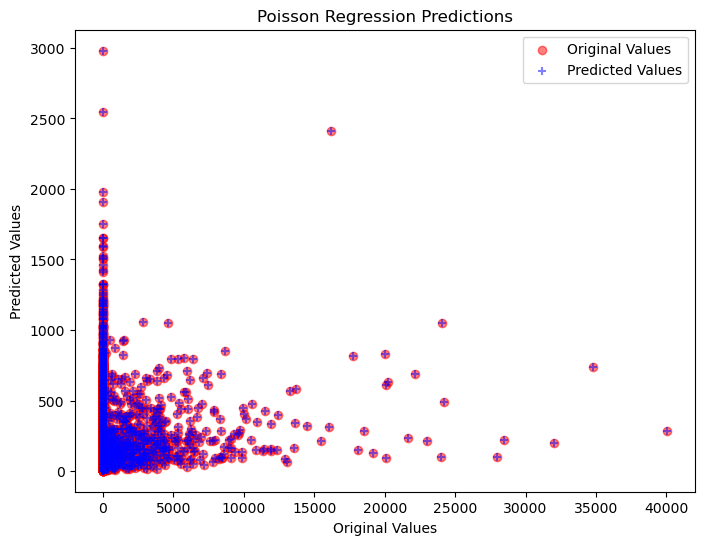

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(test_endo, predicted_values, color='red', alpha=0.5, marker='o', label='Original Values')
plt.scatter(test_endo, predicted_values, color='blue', alpha=0.5, marker='+', label='Predicted Values')
plt.title('Poisson Regression Predictions')
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

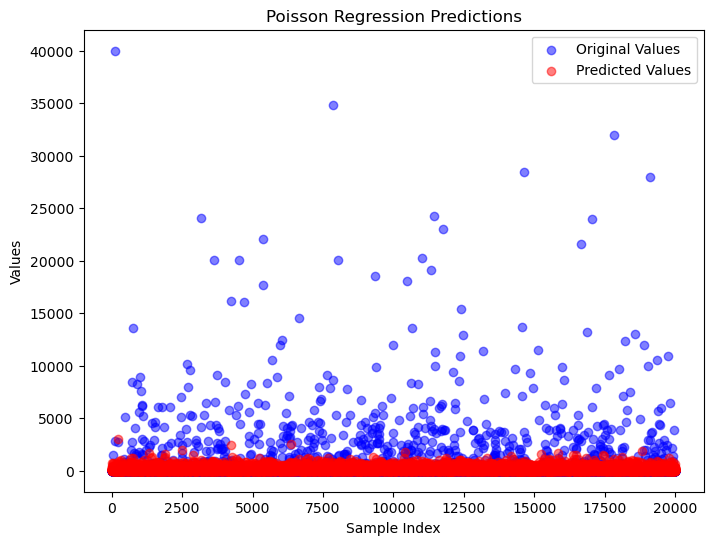

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(test_endo)), test_endo, color='blue', alpha=0.5, label='Original Values')
plt.scatter(np.arange(len(predicted_values)), predicted_values, color='red', alpha=0.5, label='Predicted Values')
plt.title('Poisson Regression Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

**Random Forest classifier on NB_Claim**

In [50]:
features = CNT_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
target = 'NB_Claim'

X = features
y = CNT_SIN_M[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
    # Predict the test set
y_pred = clf.predict(X_test)
print(clf,':')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1-score by class:', f1_score(y_test, y_pred, average='weighted'))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('')

RandomForestClassifier() :
Accuracy: 0.9603376792047554
F1-score by class: 0.941347052461199
Confusion matrix:
[[19216     0     0     0]
 [  756     9     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]



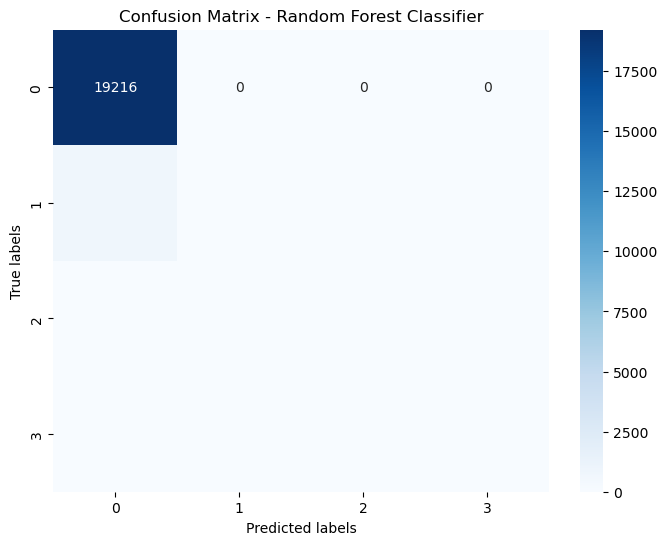

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

**Résultats du modèle RandomForestClassifier**
- Précision : 96,12 %
- Score F1 : 0,944
- Matrice de confusion :
  - Vrais positifs : 27 pour la classe "1", 2 pour la classe "2"
  - Faux positifs : 3 pour la classe "0", 738 pour la classe "1", 32 pour la classe "2"
  - Vrais négatifs : 19 213 pour la classe "0"
  - Faux négatifs : Aucun pour la classe "3"

**Remarque :** 
- La variable "territory" n'a pas été supprimée comme mentionné précédemment, sans impact significatif sur les résultats. Le modèle a été appliqué directement sur l'ensemble de données complet.

## TEL_SIN 

In [52]:
DB_TELEMATICS2 = pd.read_csv('DB_TELEMATICS2.csv')

In [53]:
DB_SIN2 = pd.read_csv('DB_SIN2.csv')

In [54]:
DB_TELEMATICS2.set_index('Id_pol',inplace=True)

In [55]:
TEL_SIN = pd.merge(DB_TELEMATICS2, DB_SIN2, on='Id_pol', how='left') # how='outer'
TEL_SIN.fillna(0 , inplace=True)
TEL_SIN.set_index('Id_pol',inplace=True)

**Calculate spearman correlation coefficient**

In [56]:
DB_TELEMATICS2.corr(method='spearman')

,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,Pct.drive.tue,Pct.drive.wed,Pct.drive.thr,Pct.drive.fri,Pct.drive.sat,Pct.drive.sun,Pct.drive.2hrs,...,Left.turn.intensity08,Left.turn.intensity09,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12
Annual.pct.driven,1.000000,0.790004,0.004883,-0.055731,0.067422,0.044429,0.029122,0.056225,0.057938,0.257632,...,0.237832,0.245967,0.252736,0.244421,0.236730,0.237118,0.244735,0.254782,0.256261,0.250930
Total.miles.driven,0.790004,1.000000,0.012887,-0.080766,0.034503,0.025670,0.041920,0.105394,0.119373,0.424607,...,0.204667,0.224802,0.246912,0.250134,0.249909,0.201672,0.221301,0.244049,0.251088,0.253733
Pct.drive.mon,0.004883,0.012887,1.000000,0.117866,0.070800,-0.017944,-0.105977,-0.325986,-0.256082,-0.010639,...,0.028920,0.026599,0.023142,0.019753,0.013008,0.026488,0.025753,0.022156,0.017285,0.015437
Pct.drive.tue,-0.055731,-0.080766,0.117866,1.000000,0.160740,0.116206,-0.116178,-0.445752,-0.414665,-0.065177,...,-0.010818,-0.016250,-0.026951,-0.030770,-0.040795,-0.002169,-0.006334,-0.014562,-0.020729,-0.028294
Pct.drive.wed,0.067422,0.034503,0.070800,0.160740,1.000000,0.157258,-0.071186,-0.418027,-0.406279,-0.005823,...,0.008359,0.003005,-0.000787,-0.007251,-0.013965,0.010605,0.007081,0.003014,0.000758,-0.004293
Pct.drive.thr,0.044429,0.025670,-0.017944,0.116206,0.157258,1.000000,-0.016771,-0.388859,-0.387272,-0.001835,...,0.004786,0.003676,-0.002777,-0.007818,-0.011601,0.011277,0.008204,0.006973,0.002675,0.000172
Pct.drive.fri,0.029122,0.041920,-0.105977,-0.116178,-0.071186,-0.016771,1.000000,-0.137991,-0.210730,0.029316,...,-0.002240,-0.001341,-0.000260,0.000872,0.001496,-0.005874,-0.006022,-0.007142,-0.004257,-0.003493
Pct.drive.sat,0.056225,0.105394,-0.325986,-0.445752,-0.418027,-0.388859,-0.137991,1.000000,0.371495,0.071680,...,0.037075,0.041839,0.046896,0.049682,0.056306,0.028212,0.033175,0.037742,0.040272,0.042779
Pct.drive.sun,0.057938,0.119373,-0.256082,-0.414665,-0.406279,-0.387272,-0.210730,0.371495,1.000000,0.091224,...,0.048725,0.055323,0.065091,0.068460,0.076097,0.045013,0.049667,0.054209,0.056994,0.060381
Pct.drive.2hrs,0.257632,0.424607,-0.010639,-0.065177,-0.005823,-0.001835,0.029316,0.071680,0.091224,1.000000,...,0.019117,0.032449,0.048844,0.049841,0.052286,0.010420,0.025536,0.041350,0.045691,0.050439


**Analyse de composantes principales PCA**

In [57]:
TEL_SIN.isna().sum()

Annual.pct.driven         0
Total.miles.driven        0
Pct.drive.mon             0
Pct.drive.tue             0
Pct.drive.wed             0
Pct.drive.thr             0
Pct.drive.fri             0
Pct.drive.sat             0
Pct.drive.sun             0
Pct.drive.2hrs            0
Pct.drive.3hrs            0
Pct.drive.4hrs            0
Pct.drive.wkday           0
Pct.drive.wkend           0
Pct.drive.rush am         0
Pct.drive.rush pm         0
Avgdays.week              0
Accel.06miles             0
Accel.08miles             0
Accel.09miles             0
Accel.11miles             0
Accel.12miles             0
Accel.14miles             0
Brake.06miles             0
Brake.08miles             0
Brake.09miles             0
Brake.11miles             0
Brake.12miles             0
Brake.14miles             0
Left.turn.intensity08     0
Left.turn.intensity09     0
Left.turn.intensity10     0
Left.turn.intensity11     0
Left.turn.intensity12     0
Right.turn.intensity08    0
Right.turn.intensity

**Application de PCA**

In [58]:
from sklearn.decomposition import PCA

X = TEL_SIN.drop(['AMT_Claim','NB_Claim'], axis=1)
y = TEL_SIN['AMT_Claim']

# Standardiser les données
X_standardized = (X - X.mean()) / X.std()

# Effectuer l'ACP
pca = PCA()
pca.fit(X_standardized)

# Identifier les composantes principales qui expliquent la variance de manière significative
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = 0
n_selected_components = 0
for i, ratio in enumerate(explained_variance_ratio):
    total_variance += ratio
    if total_variance >= 0.95:  # Sélectionnez les composantes expliquant 95% de la variance
        n_selected_components = i + 1
        break

# Trouver les variables d'origine fortement corrélées avec les composantes principales sélectionnées
selected_feature_indices = np.abs(pca.components_[:n_selected_components]).argmax(axis=1)
selected_features = X.columns[selected_feature_indices]

# Les colonnes sélectionnées sont dans selected_features
print("Colonnes sélectionnées les plus corrélées avec la variable cible :")
print(selected_features)

Colonnes sélectionnées les plus corrélées avec la variable cible :
Index(['Brake.11miles', 'Left.turn.intensity10', 'Right.turn.intensity10',
       'Pct.drive.wkday', 'Pct.drive.3hrs', 'Total.miles.driven',
       'Brake.06miles', 'Pct.drive.mon', 'Annual.pct.driven', 'Pct.drive.fri',
       'Pct.drive.thr', 'Pct.drive.wed', 'Avgdays.week', 'Accel.08miles',
       'Pct.drive.sun', 'Pct.drive.rush am', 'Pct.drive.2hrs'],
      dtype='object')


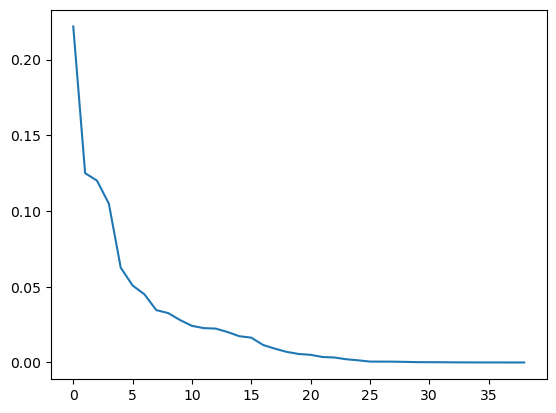

In [59]:
plt.plot(pca.explained_variance_ratio_)

In [60]:
np.cumsum(pca.explained_variance_ratio_)# 14 or 15 

array([0.22184334, 0.34683659, 0.4668947 , 0.5717275 , 0.63430998,
       0.68515351, 0.7301208 , 0.76469087, 0.79730615, 0.82532404,
       0.84949704, 0.87217927, 0.89455419, 0.91466347, 0.93200436,
       0.94839364, 0.95994048, 0.96903634, 0.9759992 , 0.98161467,
       0.98666399, 0.99027813, 0.99356486, 0.99569955, 0.99713829,
       0.9977341 , 0.99830051, 0.99884181, 0.99923744, 0.9994519 ,
       0.99963675, 0.99979754, 0.99989187, 0.99994554, 0.99997022,
       0.99998647, 1.        , 1.        , 1.        ])

- Le ratio cumulatif de variance expliquée indique que la conservation de 14 ou 15 composantes principales explique environ 99,36% ou 99,57% de la variance totale dans les données, respectivement. Cela suggère que chaque choix capture la majorité de la variabilité présente dans l'ensemble de données d'origine, avec un léger avantage pour la conservation de 15 composantes.

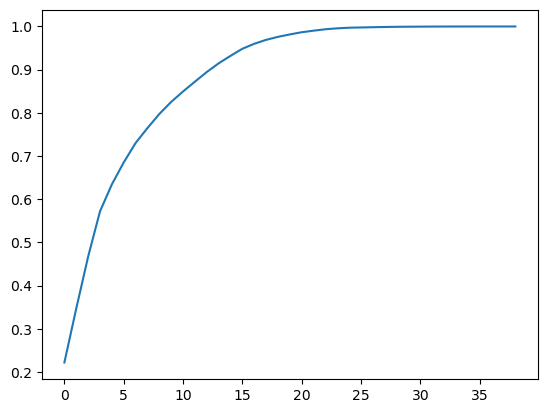

In [61]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

<BarContainer object of 39 artists>

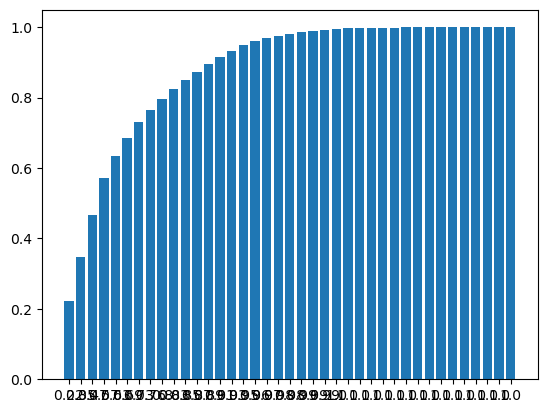

In [62]:
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5,
        np.cumsum(pca.explained_variance_ratio_), 
        tick_label=np.round(np.cumsum(pca.explained_variance_ratio_),2))

In [63]:
n = X_standardized .shape[0]   # lines               
p = X_standardized .shape[1]   # cols

In [64]:
var_cor = (n-1)/n*pca.explained_variance_  # Variance corrigée
corvar = np.zeros((p,p))
var_cor_rac = np.sqrt(var_cor)
for k in range(p):
 corvar[:,k] = pca.components_[k,:] * var_cor_rac[k] #corr = vect pr. x val pr.
print(corvar)

[[-4.57037464e-02  1.28475901e-02 -3.17922972e-03 ...  1.54650596e-06
   1.04669958e-19  5.63688394e-23]
 [-6.93198406e-02  1.57104288e-02 -5.24363086e-03 ... -1.43507644e-06
  -2.17572553e-19 -5.52940877e-23]
 [ 2.99129145e-02 -1.95391933e-02  1.26257852e-03 ... -1.75031853e-05
  -2.57229469e-09  3.72117364e-14]
 ...
 [ 3.76613883e-03  3.12211326e-01  9.42847013e-01 ...  1.36921615e-04
  -5.06357294e-19 -5.51577063e-23]
 [ 2.81875631e-03  3.06906293e-01  9.30219402e-01 ... -1.77697154e-04
   1.17435122e-18  4.97828032e-23]
 [ 1.91768698e-03  2.99273195e-01  9.11519558e-01 ...  7.46336370e-05
  -1.23329530e-18 -7.63021179e-24]]


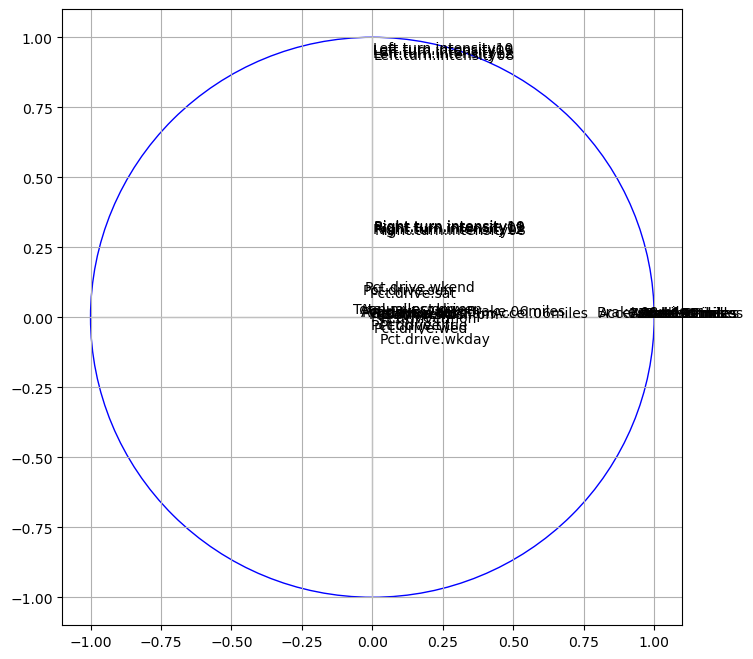

In [65]:
# Cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
#affichage des étiquettes (noms des variables)
for j in range(p):
 plt.annotate(TEL_SIN.columns[j],(corvar[j,0],corvar[j,1]))
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
plt.grid(True)
#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

**L'objectif de cette analyse ACP**  
- Cet extrait de code réalise une Analyse en Composantes Principales (ACP) sur les données de TEL_SIN afin de réduire la dimensionnalité tout en conservant l'information essentielle. Il identifie les variables les plus corrélées avec les composantes principales sélectionnées. Les colonnes sélectionnées sont : 'Brake.11miles', 'Left.turn.intensity10', 'Right.turn.intensity10', 'Pct.drive.wkday', 'Pct.drive.3hrs', 'Total.miles.driven', 'Brake.06miles', 'Pct.drive.mon', 'Pct.drive.fri', 'Pct.drive.tue', 'NB_Claim', 'Pct.drive.wed', 'Avgdays.week', 'Accel.08miles', 'Pct.drive.sun', 'Pct.drive.rush am', 'Pct.drive.2hrs'.

**Calculer la corrélation entre DB_TELEMATICS et la variable cible AMT_Claim**

In [66]:
TEL_SIN.select_dtypes(include=['float64']).corr(method='spearman')['AMT_Claim']

Annual.pct.driven         0.158955
Total.miles.driven        0.168210
Pct.drive.mon             0.013941
Pct.drive.tue            -0.002143
Pct.drive.wed             0.004468
Pct.drive.thr             0.026094
Pct.drive.fri             0.003142
Pct.drive.sat             0.004071
Pct.drive.sun             0.003974
Pct.drive.2hrs            0.065629
Pct.drive.3hrs            0.068990
Pct.drive.4hrs            0.049739
Pct.drive.wkday          -0.000900
Pct.drive.wkend           0.000900
Pct.drive.rush am         0.015138
Pct.drive.rush pm         0.036575
Avgdays.week              0.032075
Accel.06miles             0.051356
Accel.08miles             0.058215
Accel.09miles             0.048561
Accel.11miles             0.037723
Accel.12miles             0.029035
Accel.14miles             0.026308
Brake.06miles             0.061049
Brake.08miles             0.075103
Brake.09miles             0.078509
Brake.11miles             0.076530
Brake.12miles             0.064040
Brake.14miles       

In [67]:
correlation_result = TEL_SIN.select_dtypes(include=['float64']).corr(method='spearman')['AMT_Claim']
filtered_correlations = correlation_result[abs(correlation_result) > 0.80]
print(filtered_correlations)

NB_Claim     0.948941
AMT_Claim    1.000000
Name: AMT_Claim, dtype: float64


*Calculate Spearman correlation for each column and extract p-values*

In [68]:
data = TEL_SIN.select_dtypes(include=['float64']).dropna()
# Calculate Spearman correlation for each column and extract p-values
correlation_results = {column: spearmanr(data['AMT_Claim'], data[column])[1] for column in data.columns[1:]}
# Filter correlations with absolute value > 0.5 and print p-values
significant_p_values = {column: p_value for column, p_value in correlation_results.items() if abs(p_value) < 0.05}
print("Significant p-values for correlations with AMT_Claim:")
for column, p_value in significant_p_values.items():
    print(f"{column}: p-value = {p_value}")

Significant p-values for correlations with AMT_Claim:
Total.miles.driven: p-value = 0.0
Pct.drive.mon: p-value = 1.0158875030175517e-05
Pct.drive.thr: p-value = 1.4224604217852593e-16
Pct.drive.2hrs: p-value = 4.285180037145119e-96
Pct.drive.3hrs: p-value = 5.227427940867794e-106
Pct.drive.4hrs: p-value = 6.142698024358331e-56
Pct.drive.rush am: p-value = 1.6426797890725037e-06
Pct.drive.rush pm: p-value = 4.990752256667218e-31
Avgdays.week: p-value = 3.067177946594725e-24
Accel.06miles: p-value = 1.6085873821540662e-59
Accel.08miles: p-value = 5.566158219096962e-76
Accel.09miles: p-value = 2.118773027228378e-53
Accel.11miles: p-value = 6.715141866204756e-33
Accel.12miles: p-value = 3.7667884223334565e-20
Accel.14miles: p-value = 8.04183199620253e-17
Brake.06miles: p-value = 2.200457902047499e-83
Brake.08miles: p-value = 2.5593463219330087e-125
Brake.09miles: p-value = 8.568834646820799e-137
Brake.11miles: p-value = 4.605773219681306e-130
Brake.12miles: p-value = 1.401719782349562e-91


*Calculate Kendall tau correlation and p-values for each column*

In [69]:
correlation_values = {}
p_values = {}
for column in TEL_SIN.columns:
    if column not in ['AMT_Claim', 'NB_Claim']:  # Check if column is not one of 'AMT_Claim' or 'NB_Claim'
        tau, p_val = kendalltau(TEL_SIN['AMT_Claim'], TEL_SIN[column])
        correlation_values[column] = tau
        p_values[column] = p_val
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])
p_values_df['p_value'] = pd.to_numeric(p_values_df['p_value'])
significant_variables = p_values_df[p_values_df['p_value'] < 0.05].index
#print("Variables with p-value < 0.05:", significant_variables)
p_values

{'Annual.pct.driven': 0.0,
 'Total.miles.driven': 0.0,
 'Pct.drive.mon': 1.005822826039806e-05,
 'Pct.drive.tue': 0.4895589782505346,
 'Pct.drive.wed': 0.16142552115660802,
 'Pct.drive.thr': 1.5777440988996262e-16,
 'Pct.drive.fri': 0.3169144478991165,
 'Pct.drive.sat': 0.19675499730615698,
 'Pct.drive.sun': 0.20490655246493894,
 'Pct.drive.2hrs': 9.76994261671462e-96,
 'Pct.drive.3hrs': 1.140098097760217e-105,
 'Pct.drive.4hrs': 7.5208344978487865e-56,
 'Pct.drive.wkday': 0.7703737682710285,
 'Pct.drive.wkend': 0.7703737682710041,
 'Pct.drive.rush am': 1.6646963260995422e-06,
 'Pct.drive.rush pm': 4.807668506928551e-31,
 'Avgdays.week': 3.333066849931897e-24,
 'Accel.06miles': 1.5812585168499418e-59,
 'Accel.08miles': 6.279815645891008e-76,
 'Accel.09miles': 2.2675852483137596e-53,
 'Accel.11miles': 6.941746485285874e-33,
 'Accel.12miles': 3.718791903017862e-20,
 'Accel.14miles': 8.023426135964184e-17,
 'Brake.06miles': 2.6960471990412375e-83,
 'Brake.08miles': 4.0759330626224083e-125

- Ces valeurs sont les p-valeurs correspondantes pour chaque variable par rapport à la variable cible AMT_Claim. Les p-valeurs mesurent le degré de signification de la corrélation entre chaque variable et la variable cible. Une p-valeur faible (inférieure à un seuil de significativité, souvent 0.05) suggère une corrélation significative. Par conséquent, les variables avec des p-valeurs très faibles sont fortement corrélées avec AMT_Claim et sont potentiellement importantes pour la prédiction de cette variable cible.


**Calculer la corrélation entre DB_TELEMATICS et la variable cible NB_Claim**

**Test Anova**

In [70]:
#TEL_SIN['NB_Claim'] = TEL_SIN['NB_Claim'].astype('category')

In [71]:
for col in TEL_SIN:
    category_groups = [TEL_SIN['NB_Claim'][TEL_SIN[col] == cat] for cat in TEL_SIN[col].unique()]
    f_statistic, p_value = f_oneway(*category_groups)
    print(f"ANOVA results for {col}:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")
    print()

ANOVA results for Annual.pct.driven:
F-statistic: 8.956177678287181
P-value: 0.0

ANOVA results for Total.miles.driven:
F-statistic: 2.132358117435874
P-value: 1.6762256363056156e-08

ANOVA results for Pct.drive.mon:
F-statistic: 3.969364723801899
P-value: 5.9741671055081305e-89

ANOVA results for Pct.drive.tue:
F-statistic: 4.977627049309131
P-value: 3.217872993382255e-104

ANOVA results for Pct.drive.wed:
F-statistic: 2.4836574123658464
P-value: 3.2884069856985224e-50

ANOVA results for Pct.drive.thr:
F-statistic: 7.575452037537073
P-value: 2.6669650550771526e-184

ANOVA results for Pct.drive.fri:
F-statistic: 5.380422479179477
P-value: 9.801203438654669e-132

ANOVA results for Pct.drive.sat:
F-statistic: 11.90322366166358
P-value: 1.948998679451086e-259

ANOVA results for Pct.drive.sun:
F-statistic: 3.634851538563296
P-value: 6.012157569614917e-83

ANOVA results for Pct.drive.2hrs:
F-statistic: 2.2938482830914984
P-value: 0.0

ANOVA results for Pct.drive.3hrs:
F-statistic: 1.9916367

C:\Users\moham\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


ANOVA results for AMT_Claim:
F-statistic: 257.0124230396923
P-value: 0.0



- Ces résultats d'ANOVA montrent des variables fortement liées à 'AMT_Claim', telles que les pourcentages de conduite par jour de la semaine, l'intensité des virages et des freinages, ainsi que le nombre de réclamations. Certaines variables, comme la conduite en semaine et le rush pm, semblent moins influentes. La variable 'NB_Claim' montre une corrélation significative avec 'AMT_Claim'.

### Modélisation paramétrique

**Note**
- *Après avoir analysé la corrélation et utilisé l'ACP, nous avons choisi les variables les plus fortement corrélées avec notre variable cible à un seuil de 95 %.*

In [72]:
# selected_features de PCA
selected_features

Index(['Brake.11miles', 'Left.turn.intensity10', 'Right.turn.intensity10',
       'Pct.drive.wkday', 'Pct.drive.3hrs', 'Total.miles.driven',
       'Brake.06miles', 'Pct.drive.mon', 'Annual.pct.driven', 'Pct.drive.fri',
       'Pct.drive.thr', 'Pct.drive.wed', 'Avgdays.week', 'Accel.08miles',
       'Pct.drive.sun', 'Pct.drive.rush am', 'Pct.drive.2hrs'],
      dtype='object')

In [73]:
TEL_SIN_M = TEL_SIN[['Brake.11miles', 'Left.turn.intensity10', 'Right.turn.intensity10',
       'Pct.drive.wkday', 'Pct.drive.3hrs', 'Total.miles.driven',
       'Brake.06miles', 'Pct.drive.mon', 'Pct.drive.fri', 'Pct.drive.fri',
       'Pct.drive.tue', 'Pct.drive.wed', 'Avgdays.week',
       'Accel.08miles', 'Pct.drive.sun', 'Pct.drive.rush am',
       'Pct.drive.2hrs', 'NB_Claim', 'AMT_Claim']]

In [74]:
TEL_SIN_M['NB_Claim'] = TEL_SIN_M['NB_Claim'].astype('object')#

C:\Users\moham\AppData\Local\Temp\ipykernel_14536\2174640006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEL_SIN_M['NB_Claim'] = TEL_SIN_M['NB_Claim'].astype('object')#


In [75]:
TEL_SIN_M.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100237 entries, 121068 to 299921
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Brake.11miles           100237 non-null  float64
 1   Left.turn.intensity10   100237 non-null  float64
 2   Right.turn.intensity10  100237 non-null  float64
 3   Pct.drive.wkday         100237 non-null  float64
 4   Pct.drive.3hrs          100237 non-null  float64
 5   Total.miles.driven      100237 non-null  float64
 6   Brake.06miles           100237 non-null  float64
 7   Pct.drive.mon           100237 non-null  float64
 8   Pct.drive.fri           100237 non-null  float64
 9   Pct.drive.fri           100237 non-null  float64
 10  Pct.drive.tue           100237 non-null  float64
 11  Pct.drive.wed           100237 non-null  float64
 12  Avgdays.week            100237 non-null  float64
 13  Accel.08miles           100237 non-null  float64
 14  Pct.drive.sun       

#### Poisson

In [76]:
# Extraire les fonctionnalités (X) et la variable cible (Y)
X = TEL_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
y = TEL_SIN_M['AMT_Claim'] 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo
train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
# test_exo= pd.get_dummies(test_exo)
test_endo_reg = test_endo
test_exo_reg = test_exo
test_exo= sm.add_constant(test_exo)

In [77]:
poisson_model = sm.GLM(train_endo, train_exo, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              AMT_Claim   No. Observations:                80189
Model:                            GLM   Df Residuals:                    80172
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.8818e+07
Date:                Mon, 29 Apr 2024   Deviance:                   7.7607e+07
Time:                        19:23:32   Pearson chi2:                 7.94e+08
No. Iterations:                    17   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

#### Gaussian

In [78]:
fam_link = sm.families.Gaussian()
model = sm.GLM(train_endo, train_exo, family=fam_link ).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
==============================================================================
Model:                  GLM                AIC:              1369040.2696     
Link Function:          Identity           BIC:              121904321647.5102
Dependent Variable:     AMT_Claim          Log-Likelihood:   -6.8450e+05      
Date:                   2024-04-29 19:23   LL-Null:          -6.8490e+05      
No. Observations:       80189              Deviance:         1.2191e+11       
Df Model:               16                 Pearson chi2:     1.22e+11         
Df Residuals:           80172              Scale:            1.5205e+06       
Method:                 IRLS                                                  
------------------------------------------------------------------------------
                         Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------------
const                  -143.5549   82.1413 -1.7477 0.0805  -304.5489   17.4392
Brake.11miles            -0.4160    0.5670 -0.7337 0.4631    -1.5272    0.6952
Left.turn.intensity10     0.0002    0.0003  0.5422 0.5877    -0.0004    0.0007
Right.turn.intensity10    0.0021    0.0005  4.5154 0.0000     0.0012    0.0030
Pct.drive.wkday         290.3425  120.8526  2.4025 0.0163    53.4757  527.2093
Pct.drive.3hrs           42.8979 1582.3204  0.0271 0.9784 -3058.3930 3144.1888
Total.miles.driven        0.0242    0.0010 23.2952 0.0000     0.0222    0.0263
Brake.06miles             0.8702    0.0579 15.0306 0.0000     0.7567    0.9836
Pct.drive.mon           -43.8754  134.6307 -0.3259 0.7445  -307.7468  219.9959
Pct.drive.fri           -29.5879   69.5701 -0.4253 0.6706  -165.9429  106.7671
Pct.drive.fri           -29.5879   69.5701 -0.4253 0.6706  -165.9429  106.7671
Pct.drive.tue          -251.0762  132.1750 -1.8996 0.0575  -510.1343    7.9820
Pct.drive.wed          -280.7513  143.5002 -1.9565 0.0504  -562.0064    0.5039
Avgdays.week             -2.9422    3.7924 -0.7758 0.4379   -10.3751    4.4907
Accel.08miles             0.5066    0.3114  1.6265 0.1038    -0.1039    1.1170
Pct.drive.sun            60.4375  144.1338  0.4193 0.6750  -222.0596  342.9345
Pct.drive.rush am      -287.8427   57.3543 -5.0187 0.0000  -400.2550 -175.4304
Pct.drive.2hrs          344.2425  813.6160  0.4231 0.6722 -1250.4156 1938.9006
==============================================================================

"""

In [79]:
import scipy.stats as st
st.shapiro(model.resid_response)

C:\Users\moham\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.13462746143341064, pvalue=0.0)

*Puisque la p_value = 0.0 est inférieure à tout niveau de signification raisonnable (0,05 ou 0,01), nous rejetons l'hypothèse nulle. Cela indique que les résidus de modèle gaussian ne sont pas distribués normalement.*

#### Gamma

In [80]:
fam_link = sm.families.Gamma()     
model2 = sm.GLM(train_endo, train_exo, family=fam_link).fit()
model2.summary2()

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                GLM                AIC:              -inf        
Link Function:        InversePower       BIC:              4669720.7996
Dependent Variable:   AMT_Claim          Log-Likelihood:   inf         
Date:                 2024-04-29 19:23   LL-Null:          inf         
No. Observations:     80189              Deviance:         5.5750e+06  
Df Model:             16                 Pearson chi2:     1.09e+07    
Df Residuals:         80172              Scale:            135.52      
Method:               IRLS                                             
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const                   0.0606   0.0025  23.8855 0.0000  0.0557  0.0656
Brake.11miles          -0.0002   0.0000 -20.7746 0.0000 -0.0002 -0.0002
Left.turn.intensity10  -0.0000   0.0000  -5.3341 0.0000 -0.0000 -0.0000
Right.turn.intensity10 -0.0000   0.0000 -21.0369 0.0000 -0.0000 -0.0000
Pct.drive.wkday        -0.0913   0.0038 -23.9253 0.0000 -0.0988 -0.0838
Pct.drive.3hrs          0.0294   0.0127   2.3260 0.0200  0.0046  0.0542
Total.miles.driven     -0.0000   0.0000 -24.2919 0.0000 -0.0000 -0.0000
Brake.06miles          -0.0000   0.0000 -23.9425 0.0000 -0.0000 -0.0000
Pct.drive.mon           0.0767   0.0032  23.9178 0.0000  0.0704  0.0830
Pct.drive.fri          -0.0027   0.0004  -6.6294 0.0000 -0.0034 -0.0019
Pct.drive.fri          -0.0027   0.0004  -6.6294 0.0000 -0.0034 -0.0019
Pct.drive.tue           0.1249   0.0052  24.1038 0.0000  0.1147  0.1351
Pct.drive.wed           0.0588   0.0027  21.8171 0.0000  0.0535  0.0641
Avgdays.week            0.0001   0.0000   1.6016 0.1092 -0.0000  0.0001
Accel.08miles          -0.0000   0.0000 -23.0696 0.0000 -0.0000 -0.0000
Pct.drive.sun          -0.0825   0.0035 -23.4963 0.0000 -0.0894 -0.0756
Pct.drive.rush am       0.0117   0.0005  22.5670 0.0000  0.0106  0.0127
Pct.drive.2hrs         -0.2205   0.0098 -22.5909 0.0000 -0.2397 -0.2014
=======================================================================

"""

- Nous avons tenté de normaliser la base de données, mais nous avons constaté que les résultats étaient similaires, sans aucune modification significative. Nous avons appliqué cette normalisation à nos modèles de Poisson et Gaussian, mais les résultats étaient presque identiques.
- Nous avons donc conservé la base de données dans sa forme originale.

In [81]:
TEL_SIN_M.isna().sum()

Brake.11miles             0
Left.turn.intensity10     0
Right.turn.intensity10    0
Pct.drive.wkday           0
Pct.drive.3hrs            0
Total.miles.driven        0
Brake.06miles             0
Pct.drive.mon             0
Pct.drive.fri             0
Pct.drive.fri             0
Pct.drive.tue             0
Pct.drive.wed             0
Avgdays.week              0
Accel.08miles             0
Pct.drive.sun             0
Pct.drive.rush am         0
Pct.drive.2hrs            0
NB_Claim                  0
AMT_Claim                 0
dtype: int64

In [82]:
TEL_SIN_M.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100237 entries, 121068 to 299921
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Brake.11miles           100237 non-null  float64
 1   Left.turn.intensity10   100237 non-null  float64
 2   Right.turn.intensity10  100237 non-null  float64
 3   Pct.drive.wkday         100237 non-null  float64
 4   Pct.drive.3hrs          100237 non-null  float64
 5   Total.miles.driven      100237 non-null  float64
 6   Brake.06miles           100237 non-null  float64
 7   Pct.drive.mon           100237 non-null  float64
 8   Pct.drive.fri           100237 non-null  float64
 9   Pct.drive.fri           100237 non-null  float64
 10  Pct.drive.tue           100237 non-null  float64
 11  Pct.drive.wed           100237 non-null  float64
 12  Avgdays.week            100237 non-null  float64
 13  Accel.08miles           100237 non-null  float64
 14  Pct.drive.sun       

#### Régression Logistique 

In [83]:
TEL_SIN_M['NB_Claim'] = TEL_SIN_M['NB_Claim'].astype('category')

C:\Users\moham\AppData\Local\Temp\ipykernel_14536\910482674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEL_SIN_M['NB_Claim'] = TEL_SIN_M['NB_Claim'].astype('category')


In [84]:
X=TEL_SIN_M.drop(['NB_Claim','AMT_Claim'],axis=1)
y=TEL_SIN_M['NB_Claim']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05) 
train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo
train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
# test_exo= pd.get_dummies(test_exo)
test_endo_reg = test_endo
test_exo_reg = test_exo
test_exo= sm.add_constant(test_exo)
train_exo.columns

Index(['const', 'Brake.11miles', 'Left.turn.intensity10',
       'Right.turn.intensity10', 'Pct.drive.wkday', 'Pct.drive.3hrs',
       'Total.miles.driven', 'Brake.06miles', 'Pct.drive.mon', 'Pct.drive.fri',
       'Pct.drive.fri', 'Pct.drive.tue', 'Pct.drive.wed', 'Avgdays.week',
       'Accel.08miles', 'Pct.drive.sun', 'Pct.drive.rush am',
       'Pct.drive.2hrs'],
      dtype='object')

**Modèle : régression logistique Multinomial , Scikit Learn**

In [85]:
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty=None, solver='newton-cg')
result = model.fit(train_exo, train_endo)

C:\Users\moham\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [86]:
ypred = result.predict(test_exo);ypred

array([0., 0., 0., ..., 0., 0., 0.])

In [87]:
import sklearn.metrics as metrics
metrics.confusion_matrix(test_endo,ypred)
print(metrics.classification_report(test_endo,ypred))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      4791
         1.0       0.00      0.00      0.00       213
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         1

    accuracy                           0.96      5012
   macro avg       0.24      0.25      0.24      5012
weighted avg       0.91      0.96      0.93      5012



C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Modèle : régression logistique Multinomial , statsmodels**

In [88]:
import statsmodels.api as sm
# Créer le modèle de régression logistique multinomiale
model = sm.MNLogit(train_endo, train_exo)
# Ajuster le modèle aux données d'entraînement
result = model.fit()
# Afficher les résumés du modèle
print(result.summary())

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3057: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3058: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Optimization terminated successfully.
         Current function value: nan
         Iterations 20
                          MNLogit Regression Results                          
Dep. Variable:               NB_Claim   No. Observations:                95225
Model:                        MNLogit   Df Residuals:                    95174
Method:                           MLE   Df Model:                           48
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                     nan
Time:                        19:25:11   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -17513.
Covariance Type:            nonrobust   LLR p-value:                       nan
            NB_Claim=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.6250        nan        nan        nan         nan         n

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:5471: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


**Modèle : régression logistique Binaire , statsmodels**

In [89]:
# Remplacer les valeurs 1, 2 et 3 par 1, et laisser les valeurs 0 pour epresentrer deux cas 
# existence et non existence de sinistre 
train_endo2 = train_endo.replace({1: 1, 2: 1, 3: 1})
test_endo2 = test_endo.replace({1: 1, 2: 1, 3: 1})

In [90]:
train_endo2.unique()

[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]

In [91]:
model = sm.Logit(train_endo2, train_exo) 
result = model.fit() 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.161566
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               NB_Claim   No. Observations:                95225
Model:                          Logit   Df Residuals:                    95208
Method:                           MLE   Df Model:                           16
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.08169
Time:                        19:25:12   Log-Likelihood:                -15385.
converged:                       True   LL-Null:                       -16754.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.7228          0       -inf      0.000      -4.723      

*Le choix des variables significative*

In [92]:
train_exo3 = train_exo[['const',
                        'Left.turn.intensity10',
                        'Right.turn.intensity10', 
                        'Pct.drive.wkday', 
                        'Total.miles.driven', 
                        'Brake.06miles', 
                        'Pct.drive.tue', 
                        'Pct.drive.wed', 
                        'Pct.drive.sun', 
                        'Pct.drive.rush am', 
                        'Pct.drive.2hrs'
]]

test_exo3 = test_exo[['const',
                        'Left.turn.intensity10',
                        'Right.turn.intensity10', 
                        'Pct.drive.wkday', 
                        'Total.miles.driven', 
                        'Brake.06miles', 
                        'Pct.drive.tue', 
                        'Pct.drive.wed', 
                        'Pct.drive.sun', 
                        'Pct.drive.rush am', 
                        'Pct.drive.2hrs'
]]

In [93]:
model = sm.Logit(train_endo2, train_exo3) 
result = model.fit() 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.161655
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               NB_Claim   No. Observations:                95225
Model:                          Logit   Df Residuals:                    95214
Method:                           MLE   Df Model:                           10
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.08118
Time:                        19:25:12   Log-Likelihood:                -15394.
converged:                       True   LL-Null:                       -16754.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.6773      0.366    -12.794      0.000      -5.394      

*Interprétation des résultats*

In [94]:
result.conf_int(alpha=0.1)

,0,1
const,-5.278627e+00,-4.075959
Left.turn.intensity10,7.080836e-07,0.000003
Right.turn.intensity10,1.740258e-06,0.000005
Pct.drive.wkday,4.322359e-01,1.881490
Total.miles.driven,1.357096e-04,0.000145
Brake.06miles,3.490356e-03,0.004047
Pct.drive.tue,-1.710522e+00,-0.118377
Pct.drive.wed,-1.841298e+00,-0.129554
Pct.drive.sun,-2.241194e+00,0.049156
Pct.drive.rush am,-2.009106e+00,-1.255947


- Ces modalités présentent des effets significatifs sur la variable cible. Par exemple, des valeurs plus élevées d'intensité de virage à gauche et à droite, de pourcentage de conduite en semaine et d'utilisation des freins sont corrélées à des montants de réclamation plus élevés. En revanche, conduire les mardis, mercredis, dimanches et pendant les heures de pointe du matin est corrélé à des montants de réclamation plus faibles. Les intervalles de confiance indiquent la plage dans laquelle les vrais coefficients ont probablement lieu.

In [95]:
result.llr_pvalue #test du rapport de vraisemblance : H0 les coefs sont nuls

0.0

In [96]:
result.fittedvalues #valeur du logit

Id_pol
185469   -3.518632
158310   -3.760320
159740   -3.067779
144236   -3.688823
204739   -3.487939
            ...   
180913   -2.058904
194922   -3.214069
151831   -4.068970
127024   -3.487532
184010   -3.227120
Length: 95225, dtype: float64

In [97]:
# En supposant que vous disposez d'un modèle ajusté nommé 'result' et de nouvelles données 'test_exo2'
predictions = result.predict(test_exo3)

In [98]:
# En supposant que vous souhaitiez utiliser un seuil de 0,5
predicted_classes = (predictions > 0.5).astype(int)
predicted_classes.shape


(5012,)

In [99]:
pd.crosstab(train_endo2,predicted_classes)
result.pred_table()

array([[9.108e+04, 9.400e+01],
       [4.037e+03, 1.400e+01]])

- Ces résultats montrent une matrice de confusion pour un modèle de classification(Binary Logistique Régression). La diagonale principale représente les prédictions correctes, tandis que les valeurs hors diagonale représentent les erreurs de classification.

In [100]:
#valeur de l'AUC
metrics.roc_auc_score(test_endo2,predicted_classes)

0.49958255061573786

Un score AUC de 0.4995 indique que le modèle ne se comporte pas beaucoup mieux qu'un choix aléatoire, ce qui signifie qu'il ne peut pas faire une distinction claire entre les classes positives et négatives ( sinistre et non sinistre). En d'autres termes, le modèle n'a pas beaucoup de capacité à prédire correctement les classes dans ce jeu de données.

### Modélisation Non-paramétrique

#### Method ensemble: NB_Claim

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# En supposant que TEL_SIN est votre DataFrame

# Définir les fonctionnalités et la cible
features = TEL_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
target = 'NB_Claim'

# Définir les X et y
X = features
y = TEL_SIN_M[target]

# Divisez les données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# Définir les classificateurs
classifiers = [
    KNeighborsClassifier(4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis()
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1)
]

# Itérer sur les classificateurs
for clf in classifiers:
    # Ajuster le modèle
    clf.fit(X_train, y_train)

    # Prédire l'ensemble de test
    y_pred = clf.predict(X_test)

    # Calculer et imprimer les métriques
    print(clf,':')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('F1-score by class:', f1_score(y_test, y_pred, average='weighted'))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('')


KNeighborsClassifier(n_neighbors=4) :
Accuracy: 0.9591480446927374
F1-score by class: 0.9470532770934879
Confusion matrix:
[[19125    92     5     0]
 [  691    98     0     0]
 [   29     1     6     0]
 [    1     0     0     0]]

DecisionTreeClassifier(max_depth=5) :
Accuracy: 0.9592478052673583
F1-score by class: 0.940342565969109
Confusion matrix:
[[19216     6     0     0]
 [  774    15     0     0]
 [   34     2     0     0]
 [    1     0     0     0]]

RandomForestClassifier() :
Accuracy: 0.9662809257781325
F1-score by class: 0.9555010198890238
Confusion matrix:
[[19212     9     1     0]
 [  634   154     1     0]
 [   27     3     6     0]
 [    1     0     0     0]]

MLPClassifier(max_iter=1000) :
Accuracy: 0.9559058260175579
F1-score by class: 0.9379044338936322
Confusion matrix:
[[19156    66     0     0]
 [  781     8     0     0]
 [   36     0     0     0]
 [    1     0     0     0]]

AdaBoostClassifier() :
Accuracy: 0.9443834796488427
F1-score by class: 0.93334143298111

C:\Users\moham\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[[9713 1961 7548    0]
 [ 237  105  447    0]
 [   7    5   24    0]
 [   0    0    1    0]]

LinearDiscriminantAnalysis() :
Accuracy: 0.9538607342378292
F1-score by class: 0.9387379461050743
Confusion matrix:
[[19094   112     1    15]
 [  756    29     1     3]
 [   34     2     0     0]
 [    0     1     0     0]]



#### Method ensemble: AMT_Claim

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
#from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Sélectionnez les fonctionnalités et la variable cible
features = TEL_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
target = 'AMT_Claim'

# Définir X et y
X = features
y = TEL_SIN_M[target]

# Divisez les données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# Définir les régresseurs
regressors = [
    RandomForestRegressor(),
    MLPRegressor(max_iter=1000),
    #SVR(),
    DecisionTreeRegressor()
]

# Itérer sur les régresseurs
for reg in regressors:
    # Ajuster le modèle
    reg.fit(X_train, y_train)

    # Prédire l'ensemble de test
    y_pred = reg.predict(X_test)

    # Calculer et imprimer les métriques
    print(reg,':')
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R2 Score:', r2_score(y_test, y_pred))
    print('')

RandomForestRegressor() :
Mean Squared Error: 1032531.835383746
R2 Score: 0.34296398190263566

MLPRegressor(max_iter=1000) :
Mean Squared Error: 1547209.996918036
R2 Score: 0.01545631747262588

DecisionTreeRegressor() :
Mean Squared Error: 2070547.8805884188
R2 Score: -0.3175618301746044



### Le Meilleur modèle

In [103]:
X=TEL_SIN_M.drop(['NB_Claim','AMT_Claim'],axis=1)
y=TEL_SIN_M['AMT_Claim']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05) 
train_endo=y_train
train_exo = X_train
# train_exo= pd.get_dummies(train_exo)
train_endo_reg = train_endo
train_exo_reg = train_exo
train_exo= sm.add_constant(train_exo)
test_endo= y_test
test_exo = X_test
# test_exo= pd.get_dummies(test_exo)
test_endo_reg = test_endo
test_exo_reg = test_exo
test_exo= sm.add_constant(test_exo)
train_exo.columns

Index(['const', 'Brake.11miles', 'Left.turn.intensity10',
       'Right.turn.intensity10', 'Pct.drive.wkday', 'Pct.drive.3hrs',
       'Total.miles.driven', 'Brake.06miles', 'Pct.drive.mon', 'Pct.drive.fri',
       'Pct.drive.fri', 'Pct.drive.tue', 'Pct.drive.wed', 'Avgdays.week',
       'Accel.08miles', 'Pct.drive.sun', 'Pct.drive.rush am',
       'Pct.drive.2hrs'],
      dtype='object')

In [104]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

fam_links = [sm.families.Gamma(), sm.families.Poisson()]

models = []
for fam_link in fam_links:
    model = sm.GLM(train_endo, train_exo, family=fam_link).fit()
    models.append(model)

results = []
for model in models:
    aic = model.aic
    bic = model.bic
    predicted_values = model.predict(test_exo)  # Predicted values
    mse = mean_squared_error(test_endo, predicted_values)  # Calculate MSE
    results.append({'AIC': aic, 'BIC': bic, 'MSE': mse})

for i, result in enumerate(results):
    print(f"Model {i+1}: AIC={result['AIC']}, BIC={result['BIC']}, MSE={result['MSE']}")

C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model 1: AIC=-inf, BIC=5532543.086705027, MSE=5431004.078681574
Model 2: AIC=92131324.26241861, BIC=91005876.81461741, MSE=1381293.9954740072


C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
C:\Users\moham\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood b

*En résumé, le Model 1 semble avoir un ajustement presque parfait aux données, mais il pourrait être trop complexe. Le Model 2 a un MSE plus bas, indiquant une meilleure performance prédictive en termes d'erreur moyenne, mais il est associé à des valeurs d'AIC et de BIC très élevées, suggérant une complexité ou un ajustement insatisfaisants aux données. notre choix est le Model 2 un compromis entre simplicité et performance prédictive*e

#### Prédiction

**le Meilleur modèle Non-paramétrique pour NB_Claim:**
 - Random Forest Classifier
        
**le Meilleur modèle Non-paramétrique pour AMT_Claim:**
 -  Random Forest Regressor
 
**le Meilleur modèle Paramétrique pour NB_Claim:**
 - Binary Logistique Régression
 
**le Meilleur modèle Paramétrique pour AMT_Claim:**
 - Poisson

#### Visualisons

**Gaussian model (On AMT_Claim)**

In [105]:
fam_link = sm.families.Poisson()
model = sm.GLM(train_endo,train_exo, family=fam_link ).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
========================================================================
Model:                GLM                AIC:              92131324.2624
Link Function:        Log                BIC:              91005876.8146
Dependent Variable:   AMT_Claim          Log-Likelihood:   -4.6066e+07  
Date:                 2024-04-29 19:48   LL-Null:          -5.0177e+07  
No. Observations:     95225              Deviance:         9.2097e+07   
Df Model:             16                 Pearson chi2:     9.36e+08     
Df Residuals:         95208              Scale:            1.0000       
Method:               IRLS                                              
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   2.7927   0.0063  445.4379 0.0000  2.7805  2.8050
Brake.11miles          -0.0015   0.0000  -77.3889 0.0000 -0.0015 -0.0015
Left.turn.intensity10   0.0000   0.0000   54.3305 0.0000  0.0000  0.0000
Right.turn.intensity10  0.0000   0.0000  452.4069 0.0000  0.0000  0.0000
Pct.drive.wkday         2.1457   0.0083  257.8071 0.0000  2.1294  2.1620
Pct.drive.3hrs         -3.2469   0.0841  -38.5920 0.0000 -3.4118 -3.0820
Total.miles.driven      0.0001   0.0000 2721.8170 0.0000  0.0001  0.0001
Brake.06miles           0.0048   0.0000 1970.4420 0.0000  0.0048  0.0048
Pct.drive.mon          -0.7923   0.0087  -90.7726 0.0000 -0.8094 -0.7752
Pct.drive.fri          -0.3508   0.0042  -82.8299 0.0000 -0.3591 -0.3425
Pct.drive.fri          -0.3508   0.0042  -82.8299 0.0000 -0.3591 -0.3425
Pct.drive.tue          -2.3361   0.0093 -251.3937 0.0000 -2.3543 -2.3179
Pct.drive.wed          -1.9199   0.0100 -192.5445 0.0000 -1.9394 -1.9004
Avgdays.week            0.0450   0.0003  160.5122 0.0000  0.0445  0.0456
Accel.08miles           0.0006   0.0000   49.0092 0.0000  0.0006  0.0006
Pct.drive.sun           0.9103   0.0109   83.4221 0.0000  0.8890  0.9317
Pct.drive.rush am      -1.8339   0.0040 -463.1198 0.0000 -1.8416 -1.8261
Pct.drive.2hrs          5.1388   0.0418  123.0775 0.0000  5.0570  5.2206
========================================================================

"""

In [106]:
predicted_values = model.predict(test_exo)

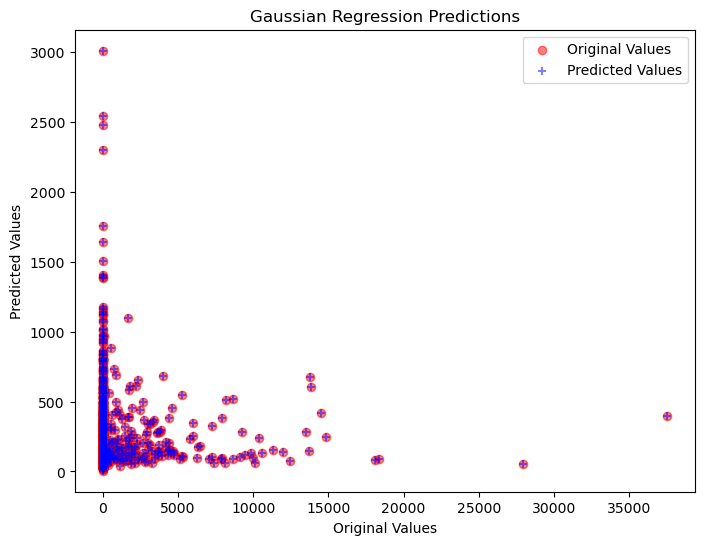

In [107]:
plt.figure(figsize=(8, 6))
plt.scatter(test_endo, predicted_values, color='red', alpha=0.5, marker='o', label='Original Values')
plt.scatter(test_endo, predicted_values, color='blue', alpha=0.5, marker='+', label='Predicted Values')
plt.title('Gaussian Regression Predictions')
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## Fine Tuning

**Nous avons sélectionné Le modèle Random Forest comme le meilleur Model pour etudie la variable NB_Claim**

In [108]:
CNT_SIN_M[ 'NB_Claim'] = CNT_SIN_M[ 'NB_Claim'].astype(int)

In [109]:
#param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [None, 10, 20],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
#}

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

X= CNT_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
y =CNT_SIN_M[ 'NB_Claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(clf,':')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1-score by class:', f1_score(y_test, y_pred, average='weighted'))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('')

RandomForestClassifier() :
Accuracy: 0.960487536840002
F1-score by class: 0.9417106393359088
Confusion matrix:
[[19216     0     0     0]
 [  753    12     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]



In [111]:
from sklearn.model_selection import GridSearchCV

# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 3, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Recherche des meilleures combinaisons d'hyperparamètres
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

# Utilisation du meilleur modèle pour les prédictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Évaluation des performances du meilleur modèle
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1-score by class:', f1_score(y_test, y_pred, average='weighted'))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))


Meilleurs paramètres trouvés :  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9605374893850842
F1-score by class: 0.9418313375685191
Confusion matrix:
[[19216     0     0     0]
 [  752    13     0     0]
 [   34     0     0     0]
 [    4     0     0     0]]


**La Base TEL_SIN le varaible y va etre AMT_Claim RandomForestRegressor**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# En supposant que CNT_SIN_M contient vos données

X = CNT_SIN_M.drop(['NB_Claim', 'AMT_Claim'], axis=1)
y = CNT_SIN_M['AMT_Claim']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# Initialiser RandomForestRegressor
regressor = RandomForestRegressor()

# Ajuster le modèle aux données d'entraînement
regressor.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = regressor.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) pour évaluer le modèle
mse = mean_squared_error(y_test, y_pred)

print(regressor, ':')
print('Mean Squared Error:', mse)


RandomForestRegressor() :
Mean Squared Error: 1147382.3608427288


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 3, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

regressor = RandomForestRegressor()

grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_regressor = RandomForestRegressor(**best_params)

best_regressor.fit(X_train, y_train)

y_pred = best_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('Best Parameters:', best_params)
print('Best Negative Mean Squared Error:', best_score)
print('Mean Squared Error:', mse)